**Step 1: Import Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Dict, Any

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

In [2]:
try:
    from xgboost import XGBRegressor
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

**Step 2: Load Dataset and Check Info**

In [3]:
df = pd.read_csv("/kaggle/input/avocado-prices-2020/avocado-updated-2020.csv")
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [4]:
df = df[[c for c in df.columns if not c.lower().startswith("unnamed")]]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33045 entries, 0 to 33044
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           33045 non-null  object 
 1   average_price  33045 non-null  float64
 2   total_volume   33045 non-null  float64
 3   4046           33045 non-null  float64
 4   4225           33045 non-null  float64
 5   4770           33045 non-null  float64
 6   total_bags     33045 non-null  float64
 7   small_bags     33045 non-null  float64
 8   large_bags     33045 non-null  float64
 9   xlarge_bags    33045 non-null  float64
 10  type           33045 non-null  object 
 11  year           33045 non-null  int64  
 12  geography      33045 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 3.3+ MB


In [6]:
print("Shape:", df.shape)
print("Columns:", list(df.columns))

Shape: (33045, 13)
Columns: ['date', 'average_price', 'total_volume', '4046', '4225', '4770', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'type', 'year', 'geography']


In [7]:
df.columns = [c.strip() for c in df.columns]
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [8]:
df.isnull().sum()

date             0
average_price    0
total_volume     0
4046             0
4225             0
4770             0
total_bags       0
small_bags       0
large_bags       0
xlarge_bags      0
type             0
year             0
geography        0
dtype: int64

**Step 3: Exploratory Data Analysis (EDA)**

**Average Price over Time**

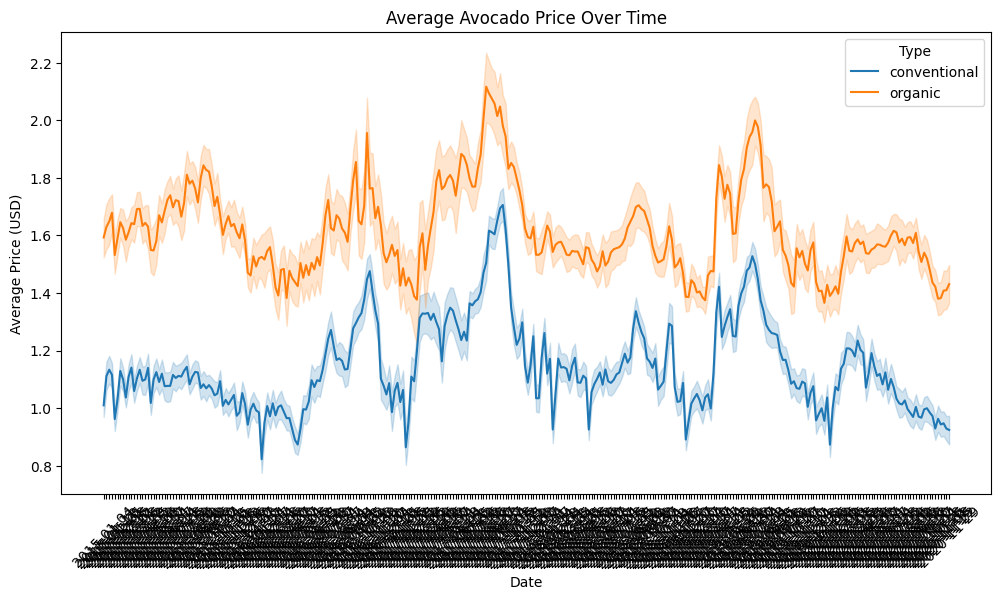

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="date", y="average_price", hue="type")
plt.title("Average Avocado Price Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price (USD)")
plt.xticks(rotation=45)
plt.legend(title="Type")
plt.show()

**Total Volume Over Time**

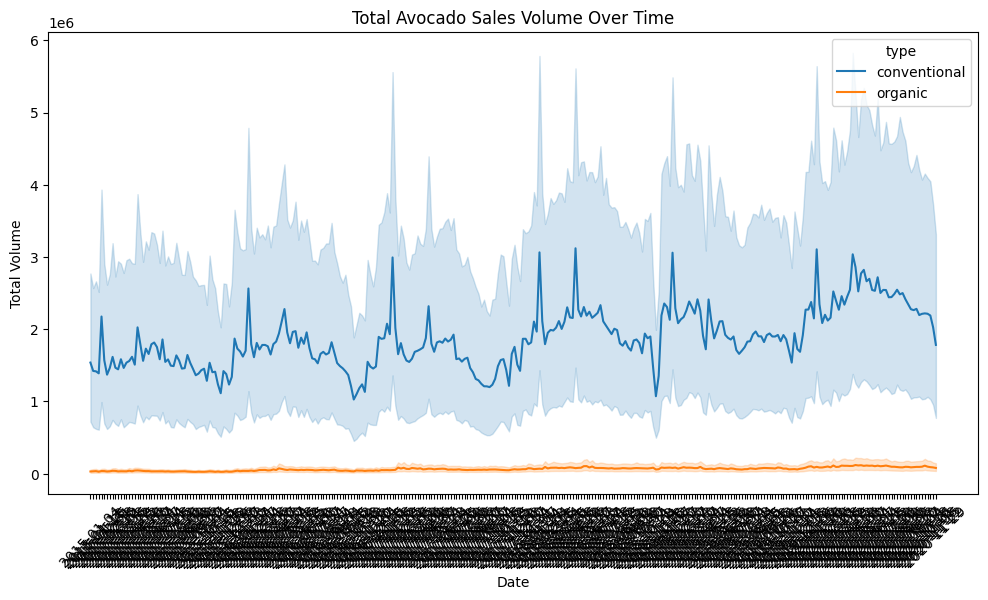

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="date", y="total_volume", hue="type")
plt.title("Total Avocado Sales Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Total Volume")
plt.xticks(rotation=45)
plt.show()

**Average Price by Geography (Top 10 Regions)**

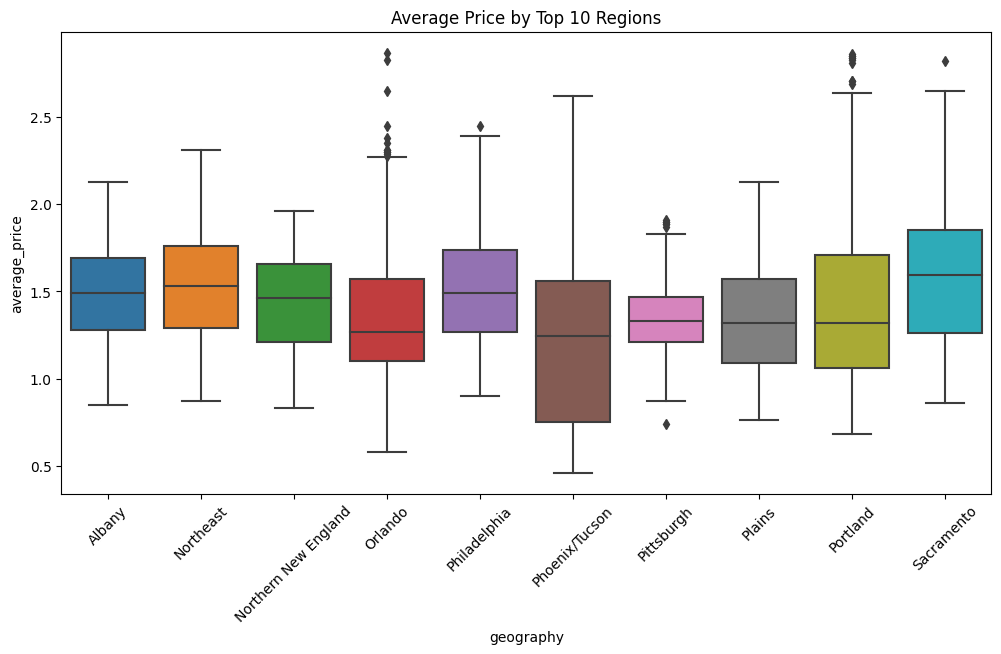

In [11]:
top_regions = df["geography"].value_counts().nlargest(10).index
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df["geography"].isin(top_regions)], x="geography", y="average_price")
plt.title("Average Price by Top 10 Regions")
plt.xticks(rotation=45)
plt.show()

**Distribution of Average Price**

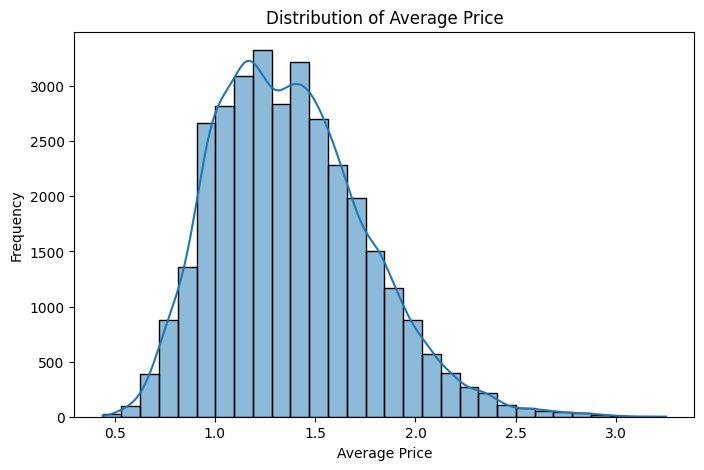

In [12]:
plt.figure(figsize=(8, 5))
sns.histplot(df["average_price"], kde=True, bins=30)
plt.title("Distribution of Average Price")
plt.xlabel("Average Price")
plt.ylabel("Frequency")
plt.show()

**Yearly Trend of Prices**

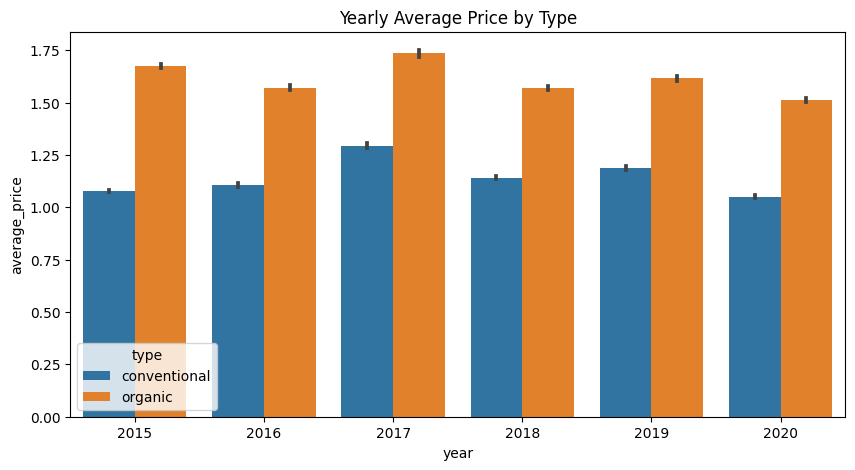

In [13]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="year", y="average_price", hue="type")
plt.title("Yearly Average Price by Type")
plt.show()

**Step 4: Column aliases**

In [14]:
DATE_COL   = "date"
TARGET     = "average_price"
REGION_COL = "geography"
TYPE_COL   = "type"
YEAR_COL   = "year"

required_cols = [
    DATE_COL, TARGET, REGION_COL, TYPE_COL, YEAR_COL,
    "total_volume", "4046", "4225", "4770",
    "total_bags", "small_bags", "large_bags", "xlarge_bags"
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    print("Warning: missing expected columns:", missing)

In [15]:
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


**Step 5: Basic cleaning and typing**

In [16]:
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.dropna(subset=[DATE_COL, TARGET]).copy()

df = df.sort_values(DATE_COL).reset_index(drop=True)
df[REGION_COL] = df[REGION_COL].astype("category")
df[TYPE_COL]   = df[TYPE_COL].astype("category")
print("\nDate range:", df[DATE_COL].min(), "→", df[DATE_COL].max())
print("Regions:", df[REGION_COL].nunique(), "| Types:", df[TYPE_COL].unique())


Date range: 2015-01-04 00:00:00 → 2020-11-29 00:00:00
Regions: 54 | Types: ['conventional', 'organic']
Categories (2, object): ['conventional', 'organic']


**Step 6: Feature engineering**

In [17]:
df["year_feat"]  = df[DATE_COL].dt.year
df["month"]      = df[DATE_COL].dt.month
df["weekofyear"] = df[DATE_COL].dt.isocalendar().week.astype(int)
df["quarter"]    = df[DATE_COL].dt.quarter

group_cols = [REGION_COL, TYPE_COL]

def add_group_lags(source_df: pd.DataFrame,
                   group_keys,
                   target_col: str,
                   lags=(1, 2, 4, 8, 12, 26, 52),
                   roll_windows=(3, 4, 8, 12, 26)):
    g = source_df.groupby(group_keys, group_keys=False)
    for L in lags:
        source_df[f"{target_col}_lag{L}"] = g[target_col].shift(L)
    for w in roll_windows:
        source_df[f"{target_col}_rollmean{w}"] = g[target_col].shift(1).rolling(w).mean()
        source_df[f"{target_col}_rollstd{w}"]  = g[target_col].shift(1).rolling(w).std()
    return source_df

df = add_group_lags(df, group_cols, TARGET, lags=(1, 2, 4, 8, 12, 26, 52), roll_windows=(3, 4, 8, 12, 26))

if "total_volume" in df.columns:
    df = add_group_lags(df, group_cols, "total_volume",
                        lags=(1, 2, 4, 8, 12, 26),
                        roll_windows=(3, 4, 8, 12, 26))
    df["volume_pct_change_1"] = df.groupby(group_cols, group_keys=False)["total_volume"].pct_change(1)
    df["volume_pct_change_4"] = df.groupby(group_cols, group_keys=False)["total_volume"].pct_change(4)

df["price_pct_change_1"] = df.groupby(group_cols, group_keys=False)[TARGET].pct_change(1)
df["price_pct_change_4"] = df.groupby(group_cols, group_keys=False)[TARGET].pct_change(4)


**Step 7: Assemble modeling frame & drop lag-induced NaNs**

In [18]:
base_numeric_features = [
    "total_volume", "4046", "4225", "4770",
    "total_bags", "small_bags", "large_bags", "xlarge_bags",
    "year_feat", "month", "weekofyear", "quarter",
    "price_pct_change_1", "price_pct_change_4",
    "volume_pct_change_1", "volume_pct_change_4",
]
lag_roll_cols = [c for c in df.columns if ("lag" in c or "roll" in c)]
numeric_features = [c for c in base_numeric_features + lag_roll_cols if c in df.columns]

categorical_features = [REGION_COL, TYPE_COL]

model_cols = [DATE_COL, TARGET] + numeric_features + categorical_features
df_model = df[model_cols].dropna().reset_index(drop=True)
print("\nAfter feature engineering & dropping NaNs:", df_model.shape)


After feature engineering & dropping NaNs: (27429, 53)


**Step 8: Time-aware train-test split**

In [19]:
unique_dates = np.array(sorted(df_model[DATE_COL].unique()))
split_idx = int(len(unique_dates) * 0.8)
split_date = unique_dates[split_idx]

train_df = df_model[df_model[DATE_COL] < split_date].copy()
test_df  = df_model[df_model[DATE_COL] >= split_date].copy()

print(f"Train dates: {train_df[DATE_COL].min()} → {train_df[DATE_COL].max()} (n={len(train_df)})")
print(f"Test  dates: {test_df[DATE_COL].min()} → {test_df[DATE_COL].max()} (n={len(test_df)})")

X_train = train_df.drop(columns=[TARGET, DATE_COL])
y_train = train_df[TARGET].values
X_test  = test_df.drop(columns=[TARGET, DATE_COL])
y_test  = test_df[TARGET].values

Train dates: 2016-01-03 00:00:00 → 2019-12-08 00:00:00 (n=21921)
Test  dates: 2019-12-15 00:00:00 → 2020-11-29 00:00:00 (n=5508)


**Step 9: Preprocessing pipelines**

In [20]:
numeric_transformer_linear = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
numeric_transformer_tree = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
preprocessor_for_linear = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_linear, [c for c in X_train.columns if c in numeric_features]),
        ("cat", categorical_transformer_dense, [c for c in X_train.columns if c in categorical_features]),
    ],
    remainder="drop"
)
preprocessor_for_tree = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_tree, [c for c in X_train.columns if c in numeric_features]),
        ("cat", categorical_transformer_dense, [c for c in X_train.columns if c in categorical_features]),
    ],
    remainder="drop"
)

**Step 10: Define Models**

In [21]:
models: Dict[str, Pipeline] = {
    "LinearRegression": Pipeline([("prep", preprocessor_for_linear), ("model", LinearRegression())]),
    "Ridge": Pipeline([("prep", preprocessor_for_linear),("model", Ridge(alpha=1.0))]),
    "Lasso": Pipeline([("prep", preprocessor_for_linear),("model", Lasso(alpha=0.001, max_iter=20000))]),
    "ElasticNet": Pipeline([("prep", preprocessor_for_linear),("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=20000))]),
    "RandomForest": Pipeline([
        ("prep", preprocessor_for_tree),("model", RandomForestRegressor(
            n_estimators=400, max_depth=None, min_samples_split=2,random_state=42, n_jobs=-1))]),
    # "GradientBoosting": Pipeline([("prep", preprocessor_for_tree),("model", GradientBoostingRegressor(random_state=42))]),
    "SVR_rbf": Pipeline([
        ("prep", preprocessor_for_linear),("model", SVR(kernel="rbf", C=3.0, epsilon=0.05))]),
}

if XGB_AVAILABLE:
    models["XGBRegressor"] = Pipeline([
        ("prep", preprocessor_for_tree),
        ("model", XGBRegressor(
            n_estimators=600, learning_rate=0.05, max_depth=6,
            subsample=0.9, colsample_bytree=0.9, objective="reg:squarederror", random_state=42, n_jobs=-1
        ))
    ])

**Step 11: Train and Evaluate**

In [22]:
def evaluate(y_true, y_pred) -> Dict[str, float]:
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = float(np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None))) * 100.0)
    return {"RMSE": rmse, "MAE": mae, "R2": r2, "MAPE_%": mape}

results: Dict[str, Dict[str, Any]] = {}
best_name, best_rmse = None, float("inf")

for name, pipe in models.items():
    print(f"\nTraining {name} (untuned) ...")
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    metrics = evaluate(y_test, preds)
    results[name] = {"metrics": metrics, "model": pipe, "preds": preds}
    print(f"{name} → RMSE={metrics['RMSE']:.4f} | MAE={metrics['MAE']:.4f} | "
          f"R2={metrics['R2']:.4f} | MAPE={metrics['MAPE_%']:.2f}%")
    if metrics["RMSE"] < best_rmse:
        best_rmse = metrics["RMSE"]
        best_name = name

print("\nEvaluation (Untuned, sorted by RMSE):")
print("\n")
unt_summary = []
for name, info in results.items():
    m = info["metrics"]
    unt_summary.append((name, m["RMSE"], m["MAE"], m["R2"], m["MAPE_%"]))
summary_untuned = pd.DataFrame(unt_summary, columns=["Model", "RMSE", "MAE", "R2", "MAPE_%"]).sort_values("RMSE")
print(summary_untuned.to_string(index=False))
print(f"\nBest untuned model by RMSE: {best_name}")


Training LinearRegression (untuned) ...
LinearRegression → RMSE=0.0302 | MAE=0.0193 | R2=0.9916 | MAPE=1.65%

Training Ridge (untuned) ...
Ridge → RMSE=0.0302 | MAE=0.0193 | R2=0.9916 | MAPE=1.65%

Training Lasso (untuned) ...
Lasso → RMSE=0.0299 | MAE=0.0188 | R2=0.9917 | MAPE=1.59%

Training ElasticNet (untuned) ...
ElasticNet → RMSE=0.0299 | MAE=0.0190 | R2=0.9917 | MAPE=1.62%

Training RandomForest (untuned) ...
RandomForest → RMSE=0.0055 | MAE=0.0023 | R2=0.9997 | MAPE=0.19%

Training SVR_rbf (untuned) ...
SVR_rbf → RMSE=0.0510 | MAE=0.0303 | R2=0.9760 | MAPE=2.74%

Training XGBRegressor (untuned) ...
XGBRegressor → RMSE=0.0072 | MAE=0.0047 | R2=0.9995 | MAPE=0.39%

Evaluation (Untuned, sorted by RMSE):


           Model     RMSE      MAE       R2   MAPE_%
    RandomForest 0.005549 0.002296 0.999715 0.194336
    XGBRegressor 0.007248 0.004693 0.999514 0.392479
           Lasso 0.029872 0.018839 0.991748 1.593257
      ElasticNet 0.029879 0.019034 0.991744 1.618157
           Rid

**Visualize predictions for best untuned model**

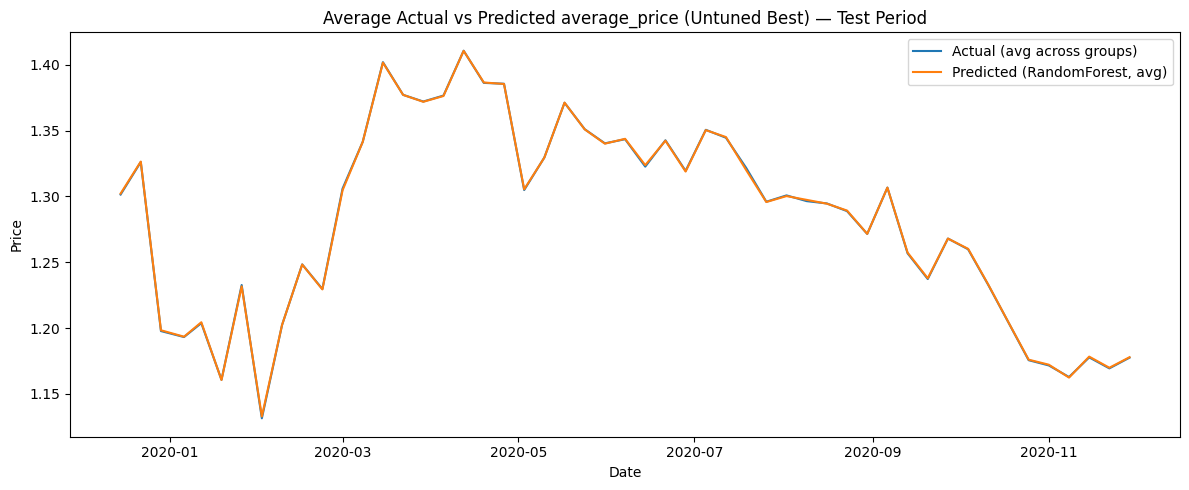

In [23]:
best_preds = results[best_name]["preds"]
plot_df = test_df[[DATE_COL, REGION_COL, TYPE_COL, TARGET]].copy()
plot_df["Pred"] = best_preds

agg_plot = plot_df.groupby(DATE_COL, as_index=False)[[TARGET, "Pred"]].mean()
plt.figure(figsize=(12,5))
plt.plot(agg_plot[DATE_COL], agg_plot[TARGET], label="Actual (avg across groups)")
plt.plot(agg_plot[DATE_COL], agg_plot["Pred"], label=f"Predicted ({best_name}, avg)")
plt.title(f"Average Actual vs Predicted {TARGET} (Untuned Best) — Test Period")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

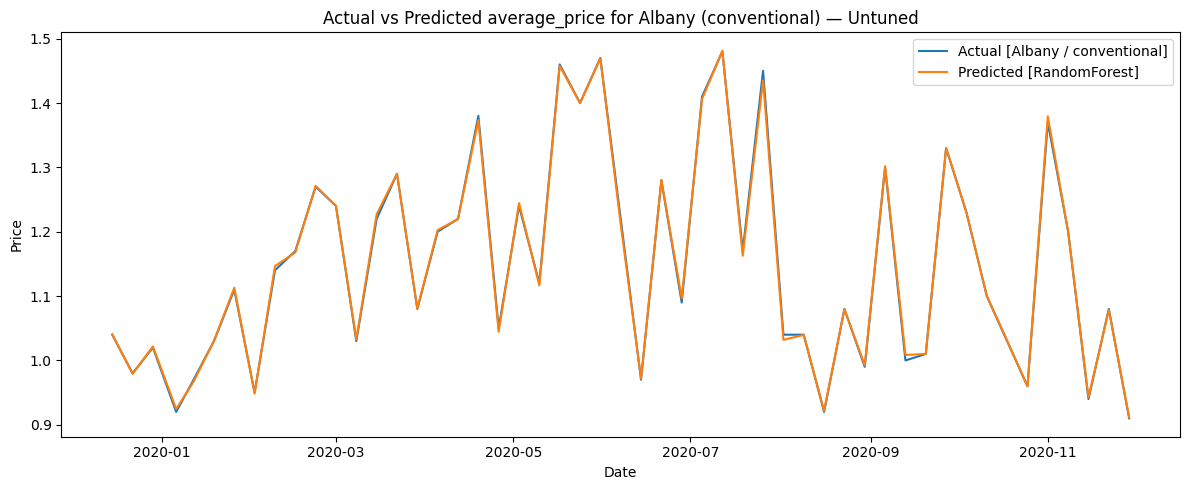

In [24]:
# Pick one sample region/type
sample_region = plot_df[REGION_COL].value_counts().index[0]
sample_type = plot_df.loc[plot_df[REGION_COL]==sample_region, TYPE_COL].value_counts().index[0]
mask = (plot_df[REGION_COL]==sample_region) & (plot_df[TYPE_COL]==sample_type)
sub = plot_df.loc[mask].sort_values(DATE_COL)

plt.figure(figsize=(12,5))
plt.plot(sub[DATE_COL], sub[TARGET], label=f"Actual [{sample_region} / {sample_type}]")
plt.plot(sub[DATE_COL], sub["Pred"], label=f"Predicted [{best_name}]")
plt.title(f"Actual vs Predicted {TARGET} for {sample_region} ({sample_type}) — Untuned")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

**Step 12: HYPERPARAMETER TUNING**

In [25]:
tscv = TimeSeriesSplit(n_splits=3)

param_grids = {
    "LinearRegression": {"model__fit_intercept": [True, False], "model__positive": [False, True]},
    "Ridge": {"model__alpha": [0.01, 0.1, 1.0, 10.0, 50.0], "model__fit_intercept": [True, False]},
    "Lasso": {"model__alpha": [0.0001, 0.001, 0.01, 0.1], "model__max_iter": [10000, 20000]},
    "ElasticNet": {"model__alpha": [0.0001, 0.001, 0.01, 0.1], "model__l1_ratio": [0.2, 0.5, 0.8], "model__max_iter": [10000, 20000]},
    "RandomForest": {"model__n_estimators": [200, 400], "model__max_depth": [None, 10, 20], "model__min_samples_split": [2, 5]},
    # "GradientBoosting": {"model__n_estimators": [100, 300], "model__learning_rate": [0.05, 0.1], "model__max_depth": [3, 5]},
    "SVR_rbf": {"model__C": [0.5, 1.0, 3.0, 10.0], "model__epsilon": [0.01, 0.05, 0.1], "model__kernel": ["rbf"]}
}

if XGB_AVAILABLE:
    param_grids["XGBRegressor"] = {
        "model__n_estimators": [300, 600],
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [4, 6, 8],
        "model__subsample": [0.8, 0.9],
        "model__colsample_bytree": [0.8, 0.9]
    }

**Step 13: Train and Evaluation with tuning**

In [26]:
tuned_results: Dict[str, Dict[str, Any]] = {}
best_tuned_name, best_tuned_rmse = None, float("inf")

for name, pipe in models.items():
    if name not in param_grids:
        print(f"\nSkipping tuning for {name} (no grid).")
        continue
    print(f"\nTuning {name} ...")
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        cv=tscv,
        scoring="neg_root_mean_squared_error",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    preds = best_model.predict(X_test)
    metrics = evaluate(y_test, preds)
    tuned_results[name] = {
        "metrics": metrics,
        "model": best_model,
        "preds": preds,
        "best_params": grid.best_params_
    }
    print(f"Best params for {name}: {grid.best_params_}")
    print(f"{name} (Tuned) → RMSE={metrics['RMSE']:.4f} | MAE={metrics['MAE']:.4f} | "
          f"R2={metrics['R2']:.4f} | MAPE={metrics['MAPE_%']:.2f}%")
    if metrics["RMSE"] < best_tuned_rmse:
        best_tuned_rmse = metrics["RMSE"]
        best_tuned_name = name

print("\nEvaluation (Tuned, sorted by RMSE): ")
print("\n")
t_summary = []
for name, info in results.items():
    m = info["metrics"]
    t_summary.append((name, m["RMSE"], m["MAE"], m["R2"], m["MAPE_%"]))
summary_tuned = pd.DataFrame(t_summary, columns=["Model", "RMSE", "MAE", "R2", "MAPE_%"]).sort_values("RMSE")
print(summary_tuned.to_string(index=False))
print(f"\nBest untuned model by RMSE: {best_name}")


Tuning LinearRegression ...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params for LinearRegression: {'model__fit_intercept': True, 'model__positive': True}
LinearRegression (Tuned) → RMSE=0.0301 | MAE=0.0182 | R2=0.9916 | MAPE=1.56%

Tuning Ridge ...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params for Ridge: {'model__alpha': 0.01, 'model__fit_intercept': True}
Ridge (Tuned) → RMSE=0.0302 | MAE=0.0193 | R2=0.9916 | MAPE=1.65%

Tuning Lasso ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params for Lasso: {'model__alpha': 0.001, 'model__max_iter': 10000}
Lasso (Tuned) → RMSE=0.0299 | MAE=0.0188 | R2=0.9917 | MAPE=1.59%

Tuning ElasticNet ...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best params for ElasticNet: {'model__alpha': 0.001, 'model__l1_ratio': 0.8, 'model__max_iter': 10000}
ElasticNet (Tuned) → RMSE=0.0299 | MAE=0.0189 | R2=0.9918 | MAPE=1.60%

Tuning RandomForest ...
Fitting 3 folds for each

In [27]:
comparison_rows = []
for name in sorted(set(list(results.keys()) + list(tuned_results.keys()))):
    unt_rmse = results[name]["metrics"]["RMSE"] if name in results else np.nan
    tun_rmse = tuned_results[name]["metrics"]["RMSE"] if name in tuned_results else np.nan
    unt_r2   = results[name]["metrics"]["R2"] if name in results else np.nan
    tun_r2   = tuned_results[name]["metrics"]["R2"] if name in tuned_results else np.nan
    comparison_rows.append((name, unt_rmse, tun_rmse, unt_r2, tun_r2))

comparison_df = pd.DataFrame(
    comparison_rows,
    columns=["Model", "Untuned_RMSE", "Tuned_RMSE", "Untuned_R2", "Tuned_R2"]
).sort_values(["Tuned_RMSE", "Untuned_RMSE"], na_position="last")

print("\nUntuned vs Tuned Models Comparison: ")
print("\n")
print(comparison_df.to_string(index=False))


Untuned vs Tuned Models Comparison: 


           Model  Untuned_RMSE  Tuned_RMSE  Untuned_R2  Tuned_R2
    RandomForest      0.005549    0.005553    0.999715  0.999715
    XGBRegressor      0.007248    0.008391    0.999514  0.999349
      ElasticNet      0.029879    0.029857    0.991744  0.991756
           Lasso      0.029872    0.029872    0.991748  0.991748
LinearRegression      0.030165    0.030069    0.991585  0.991639
           Ridge      0.030154    0.030163    0.991592  0.991586
         SVR_rbf      0.050981    0.039868    0.975965  0.985301


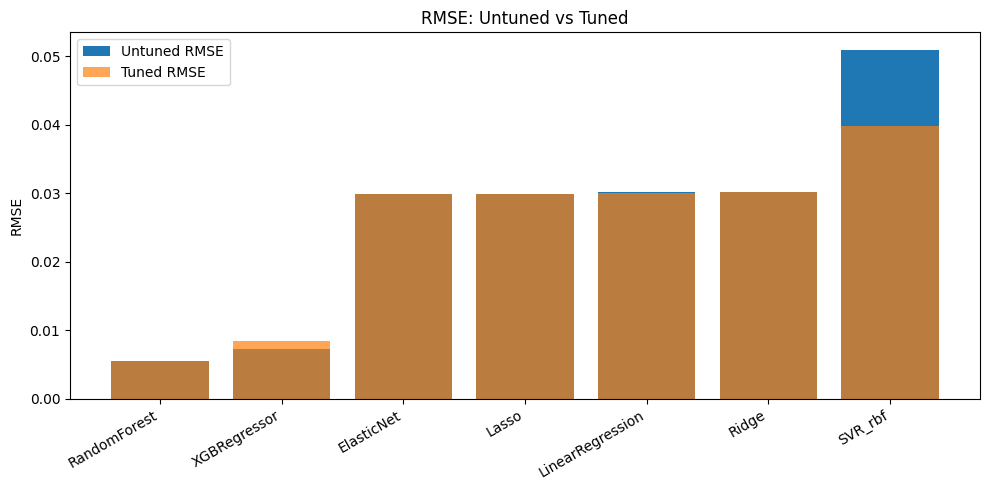

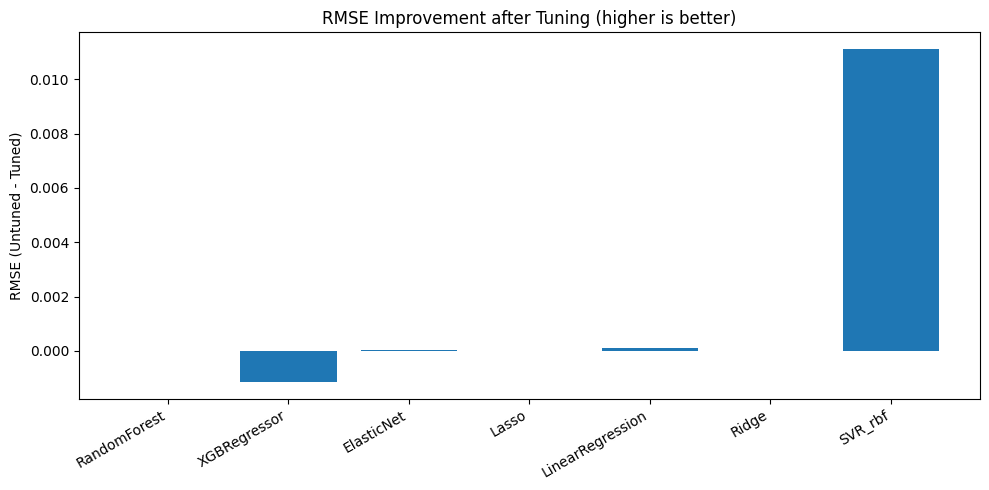

In [28]:
cd = comparison_df.dropna()
cd["RMSE_Improvement"] = cd["Untuned_RMSE"] - cd["Tuned_RMSE"]

plt.figure(figsize=(10,5))
plt.bar(cd["Model"], cd["Untuned_RMSE"], label="Untuned RMSE")
plt.bar(cd["Model"], cd["Tuned_RMSE"], bottom=None, alpha=0.7, label="Tuned RMSE")
plt.xticks(rotation=30, ha="right")
plt.ylabel("RMSE")
plt.title("RMSE: Untuned vs Tuned")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,5))
plt.bar(cd["Model"], cd["RMSE_Improvement"])
plt.xticks(rotation=30, ha="right")
plt.ylabel("RMSE (Untuned - Tuned)")
plt.title("RMSE Improvement after Tuning (higher is better)")
plt.tight_layout()
plt.show()

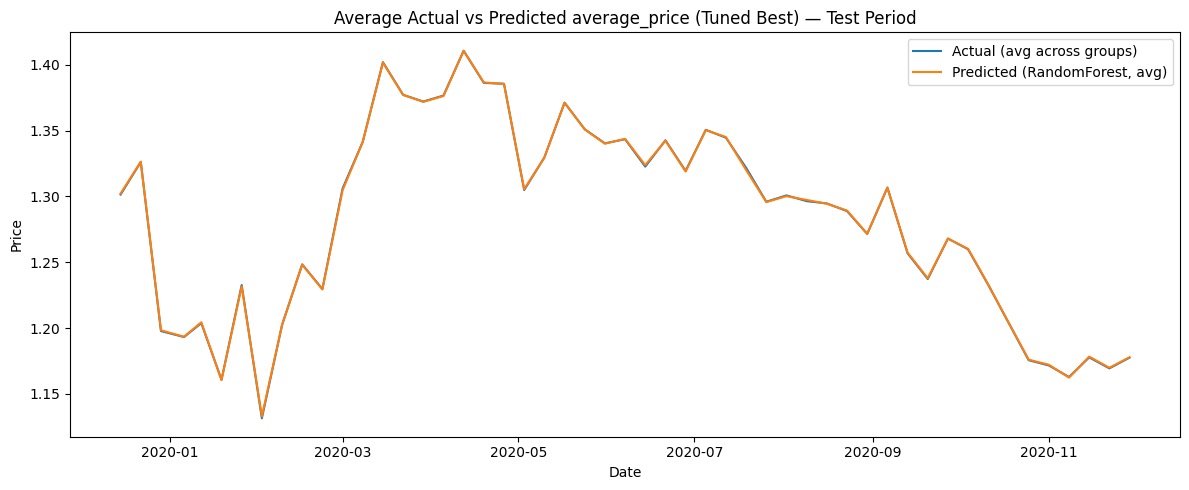

In [29]:
if best_tuned_name:
    best_tuned_preds = tuned_results[best_tuned_name]["preds"]
    plot_df_tuned = test_df[[DATE_COL, REGION_COL, TYPE_COL, TARGET]].copy()
    plot_df_tuned["Pred"] = best_tuned_preds

    agg_plot_tuned = plot_df_tuned.groupby(DATE_COL, as_index=False)[[TARGET, "Pred"]].mean()
    plt.figure(figsize=(12,5))
    plt.plot(agg_plot_tuned[DATE_COL], agg_plot_tuned[TARGET], label="Actual (avg across groups)")
    plt.plot(agg_plot_tuned[DATE_COL], agg_plot_tuned["Pred"], label=f"Predicted ({best_tuned_name}, avg)")
    plt.title(f"Average Actual vs Predicted {TARGET} (Tuned Best) — Test Period")
    plt.xlabel("Date"); plt.ylabel("Price")
    plt.legend(); plt.tight_layout(); plt.show()